# Section 4.3.3

We consider Poisson's equation 

\begin{equation}
    \nabla^2 u = f, 
\end{equation}

in a two-dimensional pie-shaped domain  $\Omega = \{(x, y) = (r\cos \theta, r\sin \theta) \, | \, 1 \le r \le 2, -1 \le \theta \le 1 \}$, using polar coordinates and homogeneous Dirichlet boundary conditions. The variational problem is then to find $u \in S^{(2)}_N \otimes S^{(2)}_N$ such that

\begin{equation}
    \int_{\Omega} \nabla^2 u v \omega d\Omega = \int_{\Omega} f v \omega d\Omega, \quad \forall v \in V^{(2)}_{N+2} \otimes V^{(2)}_{N+2}, \label{eq:laplacepolar}
\end{equation}

where $d\Omega = {r} dr d\theta$ and the two spaces $\text{V}^{(k)}_N$ and $S^{(k)}_N$ are defined in the paper as

\begin{equation}
    \text{V}^{(k)}_N = \{v \in \text{P}_N \,|\, \partial^{n}v(\pm 1) = 0, \forall\, n=0,1,\ldots, k-1\}, \label{eq:VNk}
\end{equation}

\begin{equation}
\text{S}^{(k)}_N=\{v \in \text{P}_N \,|\, \mathcal{T}^{(l)} v = 0, l=0, 1, \ldots, k-1 \},
\end{equation}

where $\mathcal{T}^{(l)}$ in general represents a Dirichlet or Neumann boundary condition. In this example it is used to represent all the homogeneous Dirichlet boundary conditions on the 4 sides of the domain.

For the radial direction we use the linear map $r=(s+3)/2$, with computational coordinate $s\in[-1,1]$. The polar coordinates lead to a Laplacian with variable coefficients that are rational functions. In order to transform this to a problem with only polynomial coefficients, we use the modified weight $(s+3)\omega$, $dr=ds/2$, and obtain for \eqref{eq:laplacepolar} in computational coordinates

\begin{equation}
    \int_{-1}^{1} \int_{-1}^{1}\left((s+3)^2\frac{\partial^2 u}{\partial s^2} + (s+3)\frac{\partial u}{\partial s} + \frac{\partial^2 u}{\partial \theta^2} \right) v \omega ds d\theta =  \int_{-1}^{1} \int_{-1}^{1} \frac{(s+3)^2f v \omega}{4}dsd\theta.
\end{equation}

Using now 

\begin{equation}
%(\partial^k u, x^q v)_{\omega} &= \left(X^{(k,q,0)}\right)^T K^T \boldsymbol{\hat{u}},\\
    (\partial^{k-l} u, s^q v)_{\omega} = L^{(k,q,l)} K^T \boldsymbol{\hat{u}}, \label{eq:varmatrix1}
\end{equation}

on all terms, and the notation $M^{(q,l)} = L^{(2,q,l)}K^T$, where $K=(\delta_{mn}-\delta_{m+2,n})_{m=0,n=0}^{N-2, N} \in \mathbb{R}^{N-1\times N+1}$ and $L^{(k,q,l)} = \underline{A}^{(k,q)}_{(k,k)} {B}^{(l)}_{(k)} \in \mathbb{R}^{M+1 \times N+1}$. The index shifted matrices $\underline{A}^{(k,q)}_{(k,k)}$ and ${B}^{(l)}_{(k)}$ are computed explicitly from Jacobi recursion operators, with $\underline{A}^{(k,q)}_{(k,k)}=(\underline{a}^{(k,q)}_{m+k,n+k}) $ and ${B}^{(l)}_{(k)} = (b^{(l)}_{m+k,n})$.

We get the algebraic problem

\begin{equation}
   \left( (M_0 + M_1) \otimes M^{(0, 2)} + M^{(0,2)} \otimes M^{(0,0)}\right) \text{vec}(\hat{U}) = \left(M_2 \otimes M^{(0,2)}\right) \text{vec}(\tilde{F}),
\end{equation}

where $M_0 = M^{(2,0)} + 6M^{(1,0)} + 9M^{(0,0)}$, $M_1= M^{(1,1)} + 3M^{(0,1)}$ and $M_2 = \tfrac{1}{4}(M^{(2, 2)} + 6 M^{(1, 2)} + 9 M^{(0, 2)})$. The coefficient matrix is sparse and strictly banded, with 28 nonzero diagonals.

## Implementation

In [1]:
from shenfun import *
import sympy as sp
import matplotlib.pyplot as plt
config['basisvectors'] = 'normal'

Define the position vector

In [2]:
s, theta = psi = sp.symbols('x,y', real=True)
r = (s+3)/2
rv = (r*sp.cos(theta), r*sp.sin(theta))

Create function spaces with curvilinear coordinates. Choose a family for the orthogonal polynomials.

In [3]:
family = 'Legendre'
#family = 'Chebyshev'

N = 20
S1 = FunctionSpace(N, family, bc=(0, 0))
V2 = FunctionSpace(N+2, family, basis='Phi2')
T = TensorProductSpace(comm, (S1, S1), coordinates=(psi, rv, sp.Q.positive(s+3)))
V = TensorProductSpace(comm, (V2, V2), coordinates=(psi, rv, sp.Q.positive(s+3)))
u = TrialFunction(T)
v = TestFunction(V)

The Jacobian, or square root of metric tensor $g$, is found as

In [4]:
T.coors.sg

x/4 + 3/4

Print the Laplace operator times $(s+3)g$ in the new coordinates. This corresponds to the integrand on the left hand side of Eq. (4.32). Note that the coordinate-free operators `div` and `grad` now work with polar coordinates.

In [5]:
from IPython.display import Math
du = div(grad(u))
Math((du*T.coors.sg*(s+3)).tolatex(symbol_names={s: 's', theta: '\\theta'}))

<IPython.core.display.Math object>

Create a manufactured solution and compute the corresponding right hand side. 

In [6]:
ue = sp.sin(2*sp.pi*theta)*(r-1)*(r-2)*sp.cos(r*sp.pi)
fe = (div(grad(u))).tosympy(basis=ue, psi=psi)

Assemble left hand side matrix and right hand side vector. Note that in curvilinear coordinates the inner product is taken as usual with measure equal to the square root of the metric tensor (or Jacobian). Hence there is a hidden measure of $(s+3)/4$ (`T.coors.sg`) in the inner product below due to curvilinear coordinates.

In [7]:
f_hat = Function(V, buffer=fe)
A = inner(div(grad(u)), v*(s+3))

Solve problem and check that it is solved correctly.

In [8]:
sol = la.Solver2D(A) # Kronecker product solver
u_hat = Function(T)
u_hat = sol(inner(v*(s+3), f_hat), u_hat)
uq = Array(T, buffer=ue)
print('L2 Error =', np.sqrt(inner(1, (u_hat.backward()-uq)**2)))

L2 Error = 8.517048705490699e-06


Look at sparsity pattern of the coefficient Kronecker product matrix

<IPython.core.display.Javascript object>


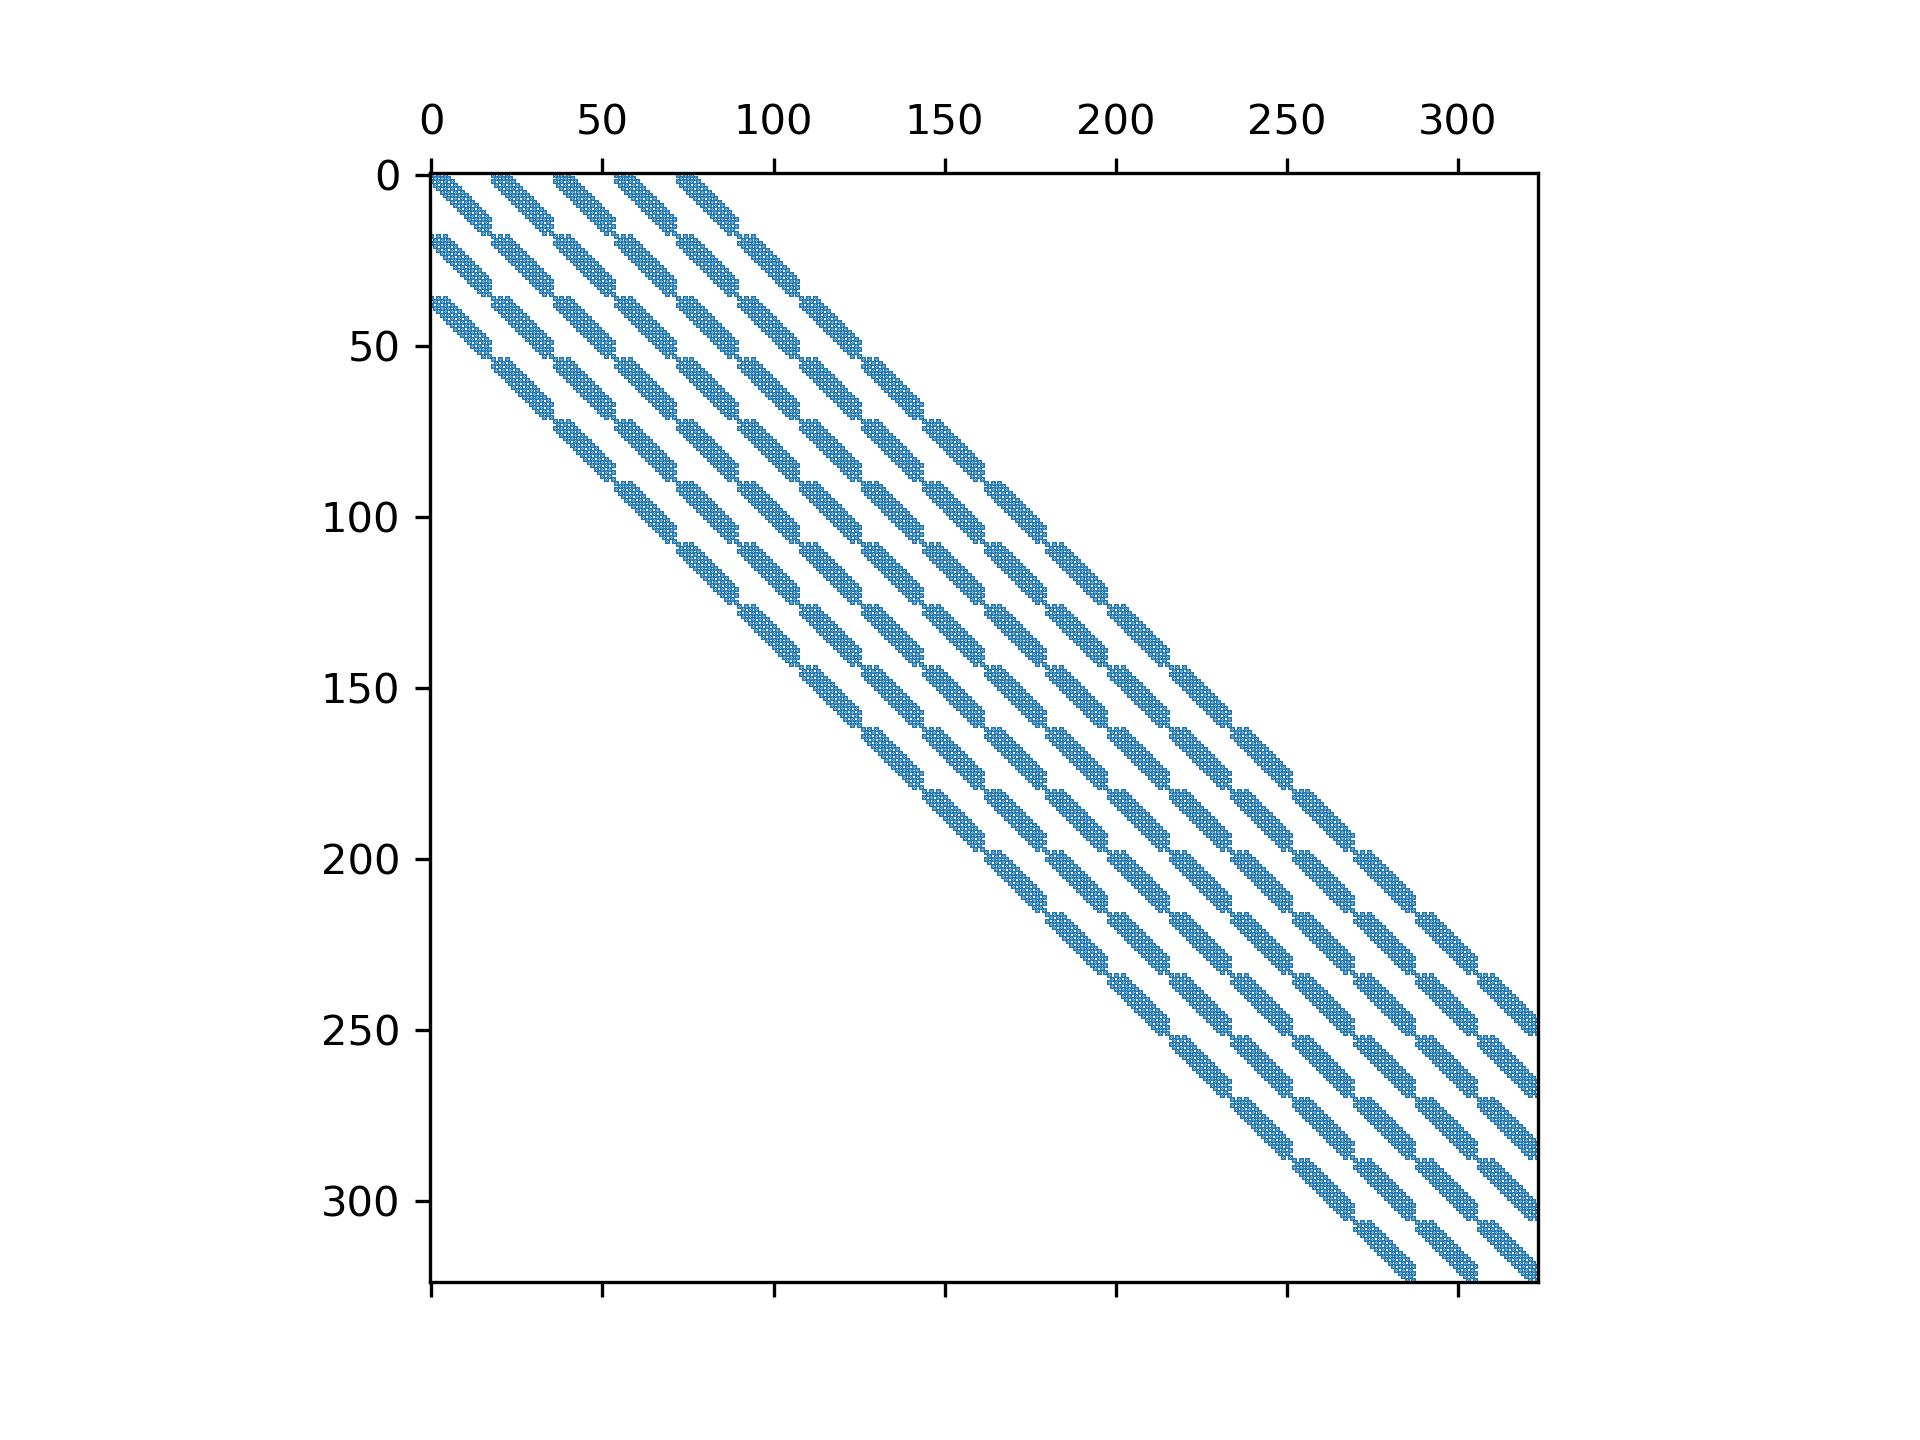

In [9]:
%matplotlib notebook
plt.spy(sol.mat, ms=0.2)

Note that there are $(N-2)^2$ degrees of freedom, and the upper bandwidth is $4 (N-1)$ and the lower is $2(N-1)$. Count the number of nonzero diagonals

In [10]:
M = extract_diagonal_matrix(sol.mat, lowerband=2*(N-1), upperband=4*(N-1))
print('The number of nonzero diagonals is', len(M))

The number of nonzero diagonals is 28


Verify that assembled matrices above correspond to Eq. (4.33) in the paper. Note that the matrix computed with `Lmat` corresponds to $L^{(k,q,l)}$. 

In [12]:
from shenfun.jacobi.recursions import *

alfa = {'Legendre': 0, 'Chebyshev': -half}[family]
M = N-2
K = S1.stencil_matrix()
K.shape = (M, N)
A0 = Lmat(2, 2, 0, M, N, alfa, alfa, cn) + 6*Lmat(2, 1, 0, M, N, alfa, alfa, cn) + 9*SparseMatrix({2: 1}, (M, N)).diags()
A00 = extract_diagonal_matrix(A0*K.diags().T)
m = extract_diagonal_matrix(A00.diags()-A[0].mats[0].diags())
assert dict(m) == {}

A1 = Lmat(2, 1, 1, M, N, alfa, alfa, cn) + 3*Lmat(2, 0, 1, M, N, alfa, alfa, cn)
A11 = extract_diagonal_matrix(A1*K.diags().T)
m1 = extract_diagonal_matrix(A11.diags()-A[1].mats[0].diags())
assert dict(m1) == {}

A2 = extract_diagonal_matrix(Lmat(2, 0, 2, M, N, alfa, alfa, cn)*K.diags().T)
m2 = extract_diagonal_matrix(A2.diags()-A[2].mats[0].diags())
assert dict(m2) == {}

If you make it here with no error, then this means the matrices computed with quadrature above (in list `A`) are equal to the explicit matrix computed with `Lmat`, and described explicitly in the paper.